<a href="https://colab.research.google.com/github/AminiV/AVeryComfyNerd/blob/main/Copy_of_personality_clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Personality CLIP

By: dzryk (discord, https://twitter.com/dzryk, https://github.com/dzryk)

This notebook provides an image captioning demo based on the dataset in "Engaging Image Captioning Via Personality" (https://arxiv.org/abs/1810.10665)

The model was trained using the cliptalk repo (https://github.com/dzryk/cliptalk)

The model combines CLIP+GPT2 (large) and was trained only on the text captions from the personality dataset.

Inspired by BitFit (https://nlp.biu.ac.il/~yogo/bitfit.pdf) we only fine-tune the bias terms of GPT2. This allows us to only need to store ~2MB of new parameters which we can then use to retrofit the existing GPT2 checkpoint.

Autofaiss knn indicies are used to bridge the gap between CLIP and GPT2. We include 4 indicies: unigrams, bigrams, art styles and emotions. Any combination of these can be used to influence the model outputs.

If you want to further custimize the generation, you can create your own indices here: https://github.com/dzryk/clip-grams

NOTE: It is recommended to use a GPU with >= 16GB memory. If your GPU has less memory you'll need to decrease the 'num_return_sequences' argument. This will affect the quality of the captions.

To get the best results, move the models params to float16 (net = retrofit.load_params(config).to(device).half()). This will cause an error with CLIP that will require a manual correction (remove the .type(float32) at https://github.com/openai/CLIP/blob/main/clip/model.py#L158). Then you should be able to use larger 'num_return_sequences' (e.g. 250 with 16GB GPU memory)

In [ ]:
!nvidia-smi

In [ ]:
!git clone https://github.com/dzryk/cliptalk.git
%cd cliptalk/
!git clone https://github.com/dzryk/clip-grams.git
!git clone https://github.com/openai/CLIP

In [ ]:
!pip3 install gdown
!pip3 install ftfy
!pip3 install transformers
!pip3 install autofaiss
!pip3 install wandb
!pip3 install webdataset
!pip3 install git+https://github.com/PyTorchLightning/pytorch-lightning

In [ ]:
# Download models and indices (total compressed size ~360MB)
!gdown https://drive.google.com/uc?id=1fhWspkaOJ31JS91sJ-85y1P597dIfavJ
!gdown https://drive.google.com/uc?id=1PJcBni9lCRroFqnQBfOJOg9gVC5urq2H
!gdown https://drive.google.com/uc?id=13Xtf7SYplE4n5Q-aGlf954m6dN-qsgjW
!gdown https://drive.google.com/uc?id=1xyjhZMbzyI-qVz-plsxDOXdqWyrKbmyS
!gdown https://drive.google.com/uc?id=1peB-l-CWtwx0NKAIeAcwsnisjocc--66

In [ ]:
# Set up directory structures
%mkdir checkpoints
%mkdir unigrams
%mkdir bigrams
%mkdir artstyles
%mkdir emotions

!unzip ./model.zip -d checkpoints
!unzip ./unigrams.zip -d unigrams
!unzip ./bigrams.zip -d bigrams
!unzip ./artstyles.zip -d artstyles
!unzip ./emotions.zip -d emotions

In [ ]:
import sys
sys.path.append('./clip-grams')
import os
import json
import argparse
import io
import numpy as np
import torch
import faiss
import glob
import torch.nn as nn
import requests
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

from CLIP import clip
from PIL import Image
from torchvision.utils import make_grid

import model
import retrofit

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

In [ ]:
# Helper functions
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def display_grid(imgs):
    reshaped = [F.to_tensor(x) for x in imgs]
    show(make_grid(reshaped))

def load_image(img, preprocess):
    img = Image.open(fetch(img))
    return img, preprocess(img).unsqueeze(0).to(device)

def clip_rescoring(args, net, candidates, x):
    textemb = net.perceiver.encode_text(
        clip.tokenize(candidates).to(args.device)).float()
    textemb /= textemb.norm(dim=-1, keepdim=True)
    similarity = (100.0 * x @ textemb.T).softmax(dim=-1)
    _, indices = similarity[0].topk(args.num_return_sequences)
    return [candidates[idx] for idx in indices[0]]

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def caption_image(path, args, net, preprocess, context):
    captions = []
    img, mat = load_image(path, preprocess)
    table, x = net.build_table(mat.half(),
                               net.perceiver,
                               ctx=context,
                               indices=net.indices,
                               indices_data=net.indices_data,
                               knn=args.knn,
                               tokenize=clip.tokenize,
                               device=args.device,
                               is_image=True,
                               return_images=True)

    table = net.tokenizer.encode(table[0], return_tensors='pt').to(device)
    table = table.squeeze()[:-1].unsqueeze(0)
    out = net.model.generate(table,
                             max_length=args.maxlen,
                             do_sample=args.do_sample,
                             num_beams=args.num_beams,
                             temperature=args.temperature,
                             top_p=args.top_p,
                             num_return_sequences=args.num_return_sequences)
    candidates = []
    for seq in out:
        decoded = net.tokenizer.decode(seq, skip_special_tokens=True)
        decoded = decoded.split('|||')[1:][0].strip()
        candidates.append(decoded)
    captions = clip_rescoring(args, net, candidates, x[None,:])
    print(f'Personality: {context[0]}\n')
    for c in captions[:args.display]:
        print(c)
    display_grid([img])
    return captions

class dotdict(dict):
    """ dot.notation access to dictionary attributes """
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [ ]:
# Settings
args = argparse.Namespace(
    config='./checkpoints/12xdqrwd-config',
    index_dirs='./unigrams,./bigrams,./artstyles,./emotions',
    clip_model='ViT-B/16',
    knn=3,
    maxlen=72,
    num_return_sequences=90,     # decrease this is you get GPU OOM, increase if using float16 model
    num_beams=1,
    temperature=0.8,
    top_p=0.9,
    display=5,
    do_sample=True,
    device=device
)

In [ ]:
# Load indices
indices = []
indices_data = []
index_dirs = args.index_dirs.split(',')
index_dirs = list(filter(lambda t: len(t) > 0, index_dirs))
for index_dir in index_dirs:
    fname = os.path.join(index_dir, 'args.txt')
    with open(fname, 'r') as f:
        index_args = dotdict(json.load(f))

    entries = []
    fname = os.path.join(index_dir, 'entries.txt')
    with open(fname, 'r') as f:
        entries.extend([line.strip() for line in f])

    indices_data.append(entries)
    indices.append(faiss.read_index(glob.glob(f"{index_dir}/*.index")[0]))
preprocess = clip.load(args.clip_model, jit=False)[1]

In [ ]:
# Load model
config = dotdict(torch.load(args.config))
config.task = 'txt2txt'
config.adapter = './checkpoints/12xdqrwd.ckpt'
net = retrofit.load_params(config).to(device)
net.indices = indices
net.indices_data = indices_data

In [ ]:
# Specify an image
img0 = 'https://www.gannett-cdn.com/-mm-/5cad672d53ae2cf4d6ce21b0495d3bb8438d5b41/c=0-94-3625-2139/local/-/media/Phoenix/ClayThompson/2014/08/21/1408663997000-Geese.jpg'

Personality: Happy

The new generation of baby geese are happy to be in Canada.
the baby geese are a joy to behold, and a beautiful reminder of the fragility of nature
These goose are taking care of their surroundings and their newborn baby.
This is a good way to introduce the new generations to the beauty of the Canadian goose.
I am so excited to see these young geese with their mother and father.


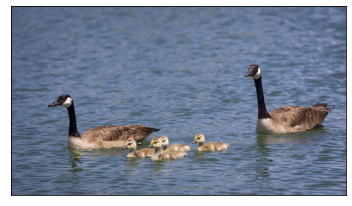

In [ ]:
# Generate captions!
# The more aligned the image is to a personality, the more likely it will work.
# Some personalities will not have an effect for certain images.
captions = caption_image(img0, args, net, preprocess, context=['Happy'])

List of personalities to try (space separated):

Adventurous
Appreciative (Grateful)
Articulate (Well-spoken, Expressive)
Attractive
Brilliant
Calm
Captivating
Caring
Charming
Cheerful
Clever
Colorful (Full of Life, Interesting)
Compassionate (Sympathetic, Warm)
Confident
Considerate
Contemplative (Reflective, Thoughtful)
Courageous
Creative
Cultured (Refined, Educated)
Curious
Daring
Deep
Dramatic
Earnest (Enthusiastic)
Elegant
Eloquent (Well-spoken, Expressive)
Empathetic
Energetic
Enthusiastic
Exciting
Extraordinary
Freethinking
Fun-loving
Gentle
Happy
Honest
Humble
Humorous
Idealistic
Imaginative
Insightful
Intelligent
Kind
Knowledgeable
Logical
Meticulous (Precise, Thorough)
Objective (Detached, Impartial)
Observant
Open
Optimistic
Passionate
Patriotic
Peaceful
Perceptive
Playful
Practical
Profound
Rational
Realistic
Reflective
Relaxed
Respectful
Romantic
Rustic (Rural)
Scholarly
Sensitive
Sentimental
Serious
Simple
Sophisticated
Spirited
Spontaneous
Stoic (Unemotional, Matter-of-fact)
Suave (Charming, Smooth)
Sweet
Sympathetic
Vivacious (Lively, Animated)
Warm
Wise
Witty
Youthful
Absentminded
Aggressive
Amusing
Artful
Boyish
Breezy (Relaxed, Informal)
Businesslike
Casual
Cerebral (Intellectual, Logical)
Complex
Conservative (Traditional, Conventional)
Contradictory
Cute
Dreamy
Dry
Emotional
Enigmatic (Cryptic, Obscure)
Formal
Glamorous
High-spirited
Impersonal
Intense
Maternal (Mother-like)
Mellow (Soothing, Sweet)
Mystical
Neutral
Old-fashioned
Ordinary
Questioning
Sarcastic
Sensual
Skeptical
Solemn
Stylish
Tough
Whimsical (Playful, Fanciful)
Abrasive (Annoying, Irritating)
Airy (Casual, Not Serious)
Aloof (Detached, Distant)
Angry
Anxious
Apathetic (Uncaring, Disinterested)
Argumentative
Arrogant
Artificial
Assertive
Barbaric
Bewildered (Astonished, Confused)
Bizarre
Bland
Blunt
Boisterous (Rowdy, Loud)
Childish
Coarse (Not Fine, Crass)
Cold
Conceited (Arrogant, Egotistical)
Confused
Contemptible (Despicable, Vile)
Cowardly
Crazy
Critical
Cruel
Cynical (Doubtful, Skeptical)
Destructive
Devious
Discouraging
Disturbing
Dull
Egocentric (Self-centered)
Envious
Erratic
Escapist (Dreamer, Seeks Distraction)
Excitable
Extravagant
Extreme
Fanatical
Fanciful
Fatalistic (Bleak, Gloomy)
Fawning (Flattering, Deferential)
Fearful
Fickle (Changeable, Temperamental)
Fiery
Foolish
Frightening
Frivolous (Trivial, Silly)
Gloomy
Grand
Grim
Hateful
Haughty (Arrogant, Snobbish)
Hostile
Irrational
Irritable
Lazy
Malicious
Melancholic
Miserable
Money-minded
Monstrous
Moody
Morbid
Narcissistic (Self-centered, Egotistical)
Neurotic (Manic, Obsessive)
Nihilistic
Obnoxious
Obsessive
Odd
Offhand
Opinionated
Outrageous
Overimaginative
Paranoid
Passive
Pompous (Self-important, Arrogant)
Pretentious (Snobbish, Showy)
Provocative
Quirky
Resentful
Ridiculous
Rigid
Rowdy
Scornful
Shy
Silly
Stiff
Stupid
Tense
Uncreative
Unimaginative
Unrealistic
Vacuous (Empty, Unintelligent)
Vague
Wishful
Zany
